# Codi per aplicar un model a una imatge donada

L'objectiu d'aquest codi és el de prendre una imatge donada dins el nostre *dataset*, i generar la respectiva versió *noisy* per a introduïr-la dins un dels nostres models i obtenir l'*output* del model corresponent.

Aquest codi en primer lloc carrega l'accés als fitxers de Google Drive.
En segon lloc, pren una imatge (de la qual hem d'especificar la ruta) i aplica una convolució amb un nucli gaussià; i després afegeix renou de tipus gaussià amb uns paràmetres donats. Després guarda la imatge en la ruta especificada.

En la darrera cel·la de codi, es pren una imatge (*noisy*) i un model donats i s'aplica el model a la respectiva imatge, guardant a la ruta especificada la imatge *output* resultant.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import os

# Funció per crear el kernel gaussià
def gaussian_kernel(size, sigma):
    x = torch.arange(size).float() - (size - 1) / 2
    y = torch.arange(size).float() - (size - 1) / 2
    x, y = torch.meshgrid(x, y, indexing="ij")
    kernel = torch.exp(-0.5 * (x ** 2 + y ** 2) / sigma ** 2)
    kernel = kernel / kernel.sum()
    return kernel

# Funció per aplicar la convolució gaussiana
def apply_gaussian_blur(image, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    kernel = kernel.unsqueeze(0).unsqueeze(0).repeat(3, 1, 1, 1)

    image_np = np.array(image).astype(np.float32)
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0)

    blurred_image = F.conv2d(image_tensor, kernel, groups=3, padding=kernel_size // 2)

    return blurred_image.squeeze(0).permute(1, 2, 0).clamp(0, 255).byte().numpy()

# Funció per afegir renou gaussià
def add_gaussian_noise(image, mean=0, std=7):
    noise = np.random.normal(mean, std, image.shape).astype(np.int16)
    noisy_image = image.astype(np.int16) + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Ruta a la imatge original
image_path = '/content/drive/MyDrive/TFG/UIB_SINGLE_IMAGE/imatges_test/imatge_satelit.jpg'

# Ruta per guardar la imatge amb blur + renou
output_path = '/content/drive/MyDrive/TFG/UIB_SINGLE_IMAGE/imatges_test/image_satelit_noisy.jpg'

# Paràmetres de blur i renou
kernel_size = 11
sigma_blur = 1.8
noise_std = 3

# Carregar imatge
image = Image.open(image_path).convert("RGB")

# Aplicar blur + renou
blurred_image = apply_gaussian_blur(image, kernel_size=kernel_size, sigma=sigma_blur)
noisy_image = add_gaussian_noise(blurred_image, std=noise_std)

# Guardar resultat
cv2.imwrite(output_path, cv2.cvtColor(noisy_image, cv2.COLOR_RGB2BGR))
print(f"Noisy image desada a: {output_path}")

Noisy image desada a: /content/drive/MyDrive/TFG/UIB_SINGLE_IMAGE/imatges_test/image_satelit_noisy.jpg


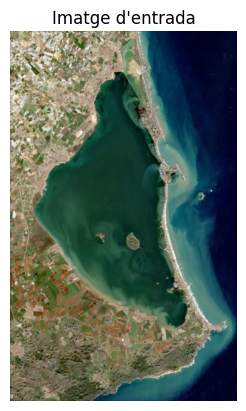

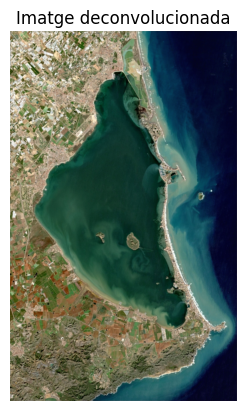

Imatge deconvolucionada desada a: /content/drive/MyDrive/TFG/UIB_SINGLE_IMAGE/imatges_test/image_satelit_Deep_unsupervised_sn2_sb1.7_kb11_May20_20-49.jpg


In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
sys.path.append('/content/drive/MyDrive/TFG/Fitxers_Python/')
from xarxa_deep import Xarxa_deep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_model = '/content/drive/MyDrive/TFG/Xarxes_guardades/Deep_unsupervised_sn2_sb1.7_kb11_May20_20-49.pth'
path_image = '/content/drive/MyDrive/TFG/UIB_SINGLE_IMAGE/imatges_test/image_satelit_noisy.jpg'
output_path = '/content/drive/MyDrive/TFG/UIB_SINGLE_IMAGE/imatges_test/image_satelit_Deep_unsupervised_sn2_sb1.7_kb11_May20_20-49.jpg'

def load_image(path):
    img = Image.open(path).convert('RGB')
    img = np.asarray(img).astype(np.float32) / 255.0
    tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # [1, C, H, W]
    return tensor.to(device)

def show_and_save(img_tensor, title, save_path=None):
    img = img_tensor.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.imsave(save_path, np.clip(img, 0, 1))
    plt.show()

def deconvolute_image():
    # Carrega model
    model = Xarxa_deep().to(device)
    model.load_state_dict(torch.load(path_model, map_location=device))
    model.eval()

    # Carrega imatge
    img_in = load_image(path_image)

    # Inference
    with torch.no_grad():
        img_out = model(img_in)

    # Mostrar resultats
    show_and_save(img_in, "Imatge d'entrada")
    show_and_save(img_out, "Imatge deconvolucionada", output_path)
    print(f"Imatge deconvolucionada desada a: {output_path}")

# Executar
deconvolute_image()